In [113]:
%pylab inline
from octopus import orbit_cm
from pygadgetreader import *
from octopus import profiles
from octopus import shapes
import biff
from astropy import constants
from astropy import units as u

Populating the interactive namespace from numpy and matplotlib


In [2]:
font = {'size':16, 'family':'serif'}
plt.matplotlib.rc('font', **font)

In [114]:
G_c = constants.G
G_c = G_c.to(u.kiloparsec**3 / (u.s**2 * u.Msun)) # 
print G_c

4.51835939627e-39 kpc3 / (s2 solMass)


## Objective: 
    
1. Found the most bounded particles of the LMC
2. What is the potential of that inner region in the outer regions

In [3]:
# Orbit of the N-body simulation
lmc_orbit = np.loadtxt('LMC_orbit/orbits/LMC6_H1.txt')

In [180]:
# Path to snaps
lmc_path = '../data/LMCMW/MWmLMC6/H1/'
lmc_snap = 'MWfLMC6H1'
N_snaps = 120

In [187]:
def mw_particles(xyz, vxyz, pot, ids, M, N_halo):
    id_cut = np.sort(ids)[N_halo]
    index_mw = np.where(ids<id_cut)[0]
    index_lmc = np.where(ids>=id_cut)[0]
    LMC_pos = xyz[index_lmc]
    LMC_vel = vxyz[index_lmc]
    LMC_pot = pot[index_lmc]
    LMC_ids = ids[index_lmc]
    LMC_mass = M[index_lmc]
    #index_cut = np.where(np.sqrt(LMC_pos[:,0]**2.0 + LMC_pos[:,1]**2.0 + LMC_pos[:,2]**2.0) <600)[0]
    return xyz[index_mw], vxyz[index_mw], M[index_mw], LMC_pos, LMC_vel, LMC_pot, LMC_ids, LMC_mass

In [182]:
def pot_contour(x, y, pot, n_bins):
    x_pot = np.linspace(min(x), max(x), n_bins)
    y_pot = np.linspace(min(y), max(y), n_bins)
    pot_grid = np.zeros((n_bins,  n_bins))

    for i in range(1,n_bins):
        for j in range(1,n_bins):
            index = np.where((x<x_pot[i]) & (x>x_pot[i-1]) & (y<y_pot[j]) & (y>y_pot[j-1]))[0]
            pot_grid[i][j] = np.mean(pot[index])
    return x_pot, y_pot, pot_grid

In [185]:
#Function that returns the radius at which the LMC is still spherical!
def sphere_radius(x,y,z):
    r = np.linspace(1, 300, 100)
    s=1
    q=1
    i =0
    while ((np.abs(s-1)< 0.1) & (np.abs(q-1)<0.1) & (i<100)):
        s, q = shapes.iterate_volume(x, y, z, r[i], 1E-2)
        i+=1
    return r[i-2]

In [278]:
# Function to select the inner particles of the halo, returns the ids of this particles
def MWLMC_all(MW_pos, LMC_pos, MW_M, LMC_M):
    MWLMC = np.concatenate((MW_pos, LMC_pos), axis=0)
    MWLMC_M = np.concatenate((MW_M, LMC_M), axis=0)
    return MWLMC, MWLMC_M

In [210]:
# Function that returns the LMC_inner particles, the mass of those particles and
# an array of masses of the lenght of the totoal LMC particles with M=0 for those
# particles outside the radius of the inner LMC particles
def mask(LMC_xyz, xcm, ycm, zcm, r, M):
    index_mask = np.where(np.sqrt((LMC_xyz[:,0]-xcm)**2.0 + (LMC_xyz[:,1]-ycm)**2.0 + (LMC_xyz[:,2]-zcm)**2.0)<r)[0]
    index_out = np.where(np.sqrt((LMC_xyz[:,0]-xcm)**2.0 + (LMC_xyz[:,1]-ycm)**2.0 + (LMC_xyz[:,2]-zcm)**2.0)>=r)[0]
    # Delete positions of the inner LMC particles
    mask_x = np.delete(LMC_xyz[:,0],index_mask)
    mask_y = np.delete(LMC_xyz[:,1],index_mask)
    mask_z = np.delete(LMC_xyz[:,2],index_mask)
    # Make new array with the inner LMC particles
    LMC_mask = np.zeros((len(mask_x),3))
    LMC_mask[:,0] = mask_x
    LMC_mask[:,1] = mask_y
    LMC_mask[:,2] = mask_z
    # Setting to 0 the mass of particles outside the spherical halo
    M_out = M
    M_out[index_out] = 0.0
    return LMC_mask, LMC_xyz[index_mask], M_out, M[index_mask]
    

In [101]:
## Code taken from (https://github.com/adrn/biff/blob/master/notebooks/Plummer%20test.ipynb)
def STnlm(xyz, mass, rs, n_max, l_max):
    nmax = n_max
    lmax = l_max

    Snlm = np.zeros((nmax+1,lmax+1,lmax+1))
    Tnlm = np.zeros((nmax+1,lmax+1,lmax+1))

    nlms = []

    for n in range(nmax+1):
        for l in range(lmax+1):
            for m in range(l+1):
                nlms.append([n,l,m])

    for nlm in nlms:
        n,l,m = nlm
        S,T = biff.compute_coeffs_discrete(np.double(xyz), np.double(mass/100.0), nlm, rs)
        Snlm[n,l,m] = S
        Tnlm[n,l,m] = T
    return Snlm, Tnlm, nlms

In [289]:
def main(lmc_path, lmc_snap, N_i, N_f, lmc_orbit):
    # For every snapshot
    for i in range(N_i, N_f+1):
        pos = readsnap(lmc_path + lmc_snap + '_{:03d}'.format(i), 'pos', 'dm')
        M = readsnap(lmc_path + lmc_snap + '_{:03d}'.format(i), 'mass', 'dm')
        vel = readsnap(lmc_path + lmc_snap + '_{:03d}'.format(i), 'vel', 'dm')
        pot = readsnap(lmc_path + lmc_snap + '_{:03d}'.format(i), 'pot', 'dm')
        pids = readsnap(lmc_path + lmc_snap + '_{:03d}'.format(i), 'pid', 'dm')
        # Distinguish between MW and LMC particles
        MW_pos, MW_vel, MW_mass, LMC_pos, LMC_vel, LMC_pot, LMC_ids, LMC_mass = mw_particles(pos, vel, pot, pids, M, 1000000)
        LMC_cx = LMC_pos[:,0] - lmc_orbit[i,2]
        LMC_cy = LMC_pos[:,1] - lmc_orbit[i,3]
        LMC_cz = LMC_pos[:,2] - lmc_orbit[i,4]
        print 'finding the rcut'
        r_cut = sphere_radius(LMC_cx, LMC_cy, LMC_cz)
        print 'masking'
        LMC_out, LMC_inn, M_out, M_inn = mask(LMC_pos, lmc_orbit[i,2], lmc_orbit[i,3], lmc_orbit[i,4], r_cut, LMC_mass)
        print np.shape(MW_mass), np.shape(M_inn)
        pos_f, mass_f = MWLMC_all(MW_pos, LMC_out, MW_mass, M_out)
    return pos_f, mass_f, LMC_inn, M_inn, MW_mass, LMC_pot

In [290]:
MWLMC, MWLMC_M, LMC_inn, M_inn, MW_mass, LMC_pot = main(lmc_path, lmc_snap, 1, 1, lmc_orbit)

finding the rcut
masking
(1000000,) (436653,)


In [241]:
print len(MWLMC)

1063347


(-500, 500)

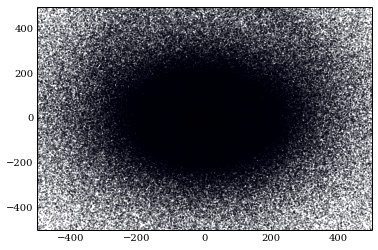

In [213]:
figure(figsize=(5,5))
scatter(MWLMC[:,0], MWLMC[:,1], s=0.1, alpha=0.5)
xlim(-500, 500)
ylim(-500, 500)

(-500, 500)

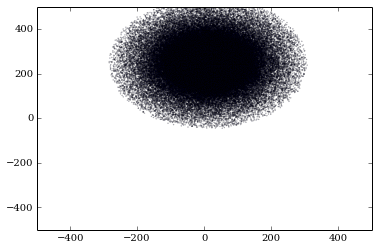

In [215]:
scatter(LMC_inn[:,0], LMC_inn[:,1], s=0.1, alpha=0.5)
xlim(-500, 500)
ylim(-500, 500)

(-500, 500)

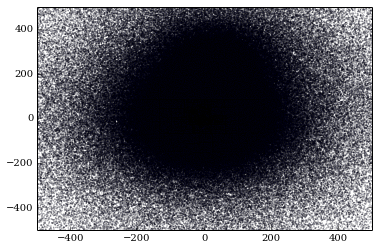

In [216]:
scatter(pos[:,0], pos[:,1], s=0.1, alpha=0.5)
xlim(-500, 500)
ylim(-500, 500)

## IDEA: 

How to compute the potential from the inner LMC? 
Compute the Snlm Tnlm coefficients of the inner LMC (in wich the lmc is spherical) and computed
in all the positions without taking the mass of the outter particles. 

In [284]:
print M_inn_t, M_out_t
print len(LMC_inn)
print sum(M_inn)*10**10 
print sum(MW_mass)*10**10

147978754044.0 1.7251902771e+12
436653
147978754044.0
1.57721328735e+12


In [300]:
r_s = 20.0
r_sMW = 40.85
M_inn_t = sum(M_inn)*10**10
M_out_t = sum(MWLMC_M)*10**10

LMC_inn_xcm = LMC_inn[:,0] - lmc_orbit[1,2]
LMC_inn_ycm = LMC_inn[:,1] - lmc_orbit[1,3]
LMC_inn_zcm = LMC_inn[:,2] - lmc_orbit[1,4]

LMC_inn_cm = np.zeros((len(LMC_inn),3))
LMC_inn_cm[:,0] = LMC_inn_xcm
LMC_inn_cm[:,1] = LMC_inn_ycm
LMC_inn_cm[:,2] = LMC_inn_zcm



MWLMC_xcm = MWLMC[:,0] - lmc_orbit[1,2]
MWLMC_ycm = MWLMC[:,1] - lmc_orbit[1,3]
MWLMC_zcm = MWLMC[:,2] - lmc_orbit[1,4]

MWLMC_cm = np.zeros((len(MWLMC),3))
MWLMC_cm[:,0] = MWLMC_xcm
MWLMC_cm[:,1] = MWLMC_ycm
MWLMC_cm[:,2] = MWLMC_zcm

## Potential of the inner LMC that feels the inner part centered at the origin:
LMC_inn_cm_d = LMC_inn_cm.astype(np.double)
Snlm, Tnlm, nlms = STnlm(LMC_inn_cm, M_inn, r_s, 10, 0)
pot_inn_inn = biff.potential(LMC_inn_cm_d, Snlm, Tnlm, 10, 0, G_c.value, M_inn_t, r_s)

## Potential of the outer MW+LMC due to the inner LMC
MWLMC_cm_d = MWLMC_cm.astype(np.double)
pot_out_inn = biff.potential(MWLMC_cm_d, Snlm, Tnlm, 10, 0, G_c.value, M_inn_t, r_s)


#pot_inn = biff.potential(MWLMC_d, Snlm, Tnlm, 10, 0, G_c.value, M_inn_t, r_s)

# 
#Snlm_LMCMW, Tnlm_LMCMW, nlms_LMCMW = STnlm(MWLMC, MWLMC_M, r_sMW, 10, 0)


In [301]:
MWLMC_d = MWLMC.astype(np.double)



In [302]:
pot_out = biff.potential(MWLMC_d, Snlm_LMCMW, Tnlm_LMCMW, 10, 0, G_c.value, M_out_t, r_sMW)



In [303]:
pot_t = pot_inn + pot_out

In [304]:
MWLMC_al = np.concatenate((MWLMC, LMC_inn), axis=0)
pot_all = np.concatenate((pot_t,pot_inn_inn), axis=0)

In [306]:
pot_factor = G_c/43007.1*1E10 
print max(LMC_pot) *pot_factor
print min(pot_inn_inn)

-1.15930536681e-29 kpc3 / (s2 solMass)
-5.20575592432e-30


ValueError: Color array must be two-dimensional

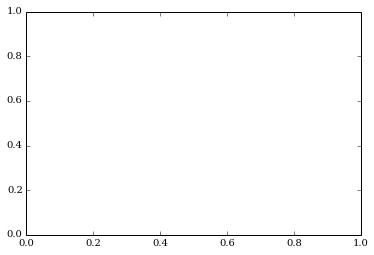

In [291]:
scatter(LMC_inn[:,0] , LMC_inn[:,1], c=LMC_pot, edgecolors='none', s=0.1)
xlim(-200, 200)
ylim(0, 400)
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f2d40c4e5a8>

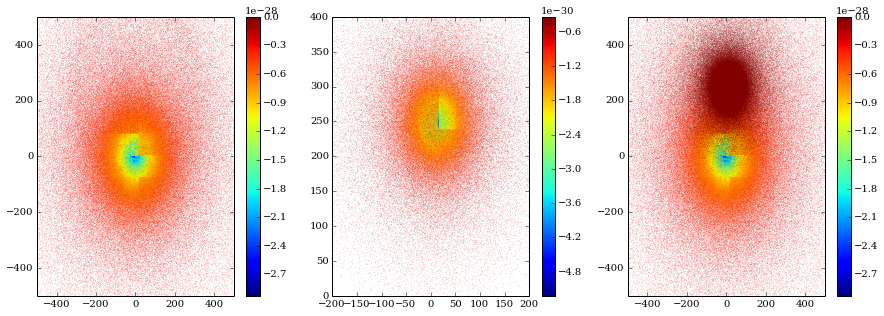

In [287]:
figure(figsize=(15,5))
subplot(1,3,1)
scatter(MWLMC[:,0], MWLMC[:,1], c=pot_t, edgecolors='none', s=0.1)
xlim(-500, 500)
ylim(-500, 500)
colorbar()

subplot(1,3,2)
scatter(LMC_inn[:,0] , LMC_inn[:,1], c=pot_inn_inn, edgecolors='none', s=0.1)
xlim(-200, 200)
ylim(0, 400)
colorbar()

subplot(1,3,3)
scatter(MWLMC_al[:,0], MWLMC_al[:,1], c=pot_all, edgecolors='none', s=0.1)
xlim(-500, 500)
ylim(-500, 500)
colorbar()

In [178]:
index_trunc = np.where((np.sqrt(LMC_pos[:,0]))<500)[0]
potx, poty, pot_grid = pot_contour(LMC_pos[:,0], LMC_pos[:,1], pot, 100)

<matplotlib.contour.QuadContourSet instance at 0x7f2d7f6cedd0>

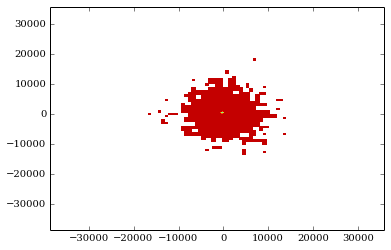

In [179]:
contourf(potx, potx, pot_grid)

In [283]:
1.5E12/2.

750000000000.0